# Анализ изменений в мобильном приложении

**Задача:** определить, повлияло ли изменение шрифта в мобильном приложении на активность пользователей.

**План:**
1. [Изучить данные.](#info)
2. [Предобработать данные.](#pp)
3. [Подготовить данные к анализу:](#prep)
   - сделать даты читаемыми,
   - избавиться от лишних данных.
4. [Проанализировать данные.](#an)
5. [Проверить гипотезы:](#hyps)
   - выдвинуть гипотезы,
   - провести статистические тесты.
6. [Написать вывод.](#conclude)

<a id='info'></a>

## Изучаем данные

In [2]:
# импортируем библиотеки, необходимые для работы
import pandas as pd # для работы с данными
import numpy as np # для работы с числами
import seaborn as sns # для визуализации
import matplotlib.pyplot as plt # для настройки визуализации
import scipy.stats as st # для проверки гипотез
import datetime as dt # для работы с датами
from statsmodels.stats.proportion import proportions_ztest # для теста пропорций
%matplotlib inline
%config InlineBackend.figure_format='retina' # повышение четкости графиков
plt.style.use('seaborn-darkgrid') # задаём стиль графиков
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Прочитаем файл с данными.

In [3]:
df = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

Посмотрим на общую информацию о датасете.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


<a id='pp'></a>

Пропусков в данных нет, типы данных правильные. Изменим названия столбцов на более короткие удобные.

In [5]:
df.columns = ['event', 'id', 'timestamp', 'group']

Проверим данные на наличие дубликатов.

In [6]:
df.duplicated().sum()

413

Удалим дубликаты.

In [7]:
df = df.drop_duplicates()

### Вывод

Данные в целом в порядке: типы правильные, пропусков нет. Мы изменили названия столбцов на более удобные для работы и удалили чуть больше 400 дублирующихся строк. Теперь данные чистые, и с ними можно работать.

<a id='prep'></a>

## Готовим данные к анализу

Создадим столбцы с датой и временем в читаемом формате, а затем создадим столбец только с датой.

In [8]:
df['date'] = pd.to_datetime(df['timestamp'], unit='s')

In [9]:
df['day'] = df['date'].dt.date

Посмотрим на распределение данных.

In [10]:
df.describe(include='all', datetime_is_numeric=True)

,event,id,timestamp,group,date,day
count,243713,2.437130e+05,2.437130e+05,243713.000000,243713,243713
unique,5,NaN,NaN,NaN,NaN,14
top,MainScreenAppear,NaN,NaN,NaN,NaN,2019-08-01
freq,119101,NaN,NaN,NaN,NaN,36141
mean,NaN,4.627963e+18,1.564914e+09,247.022161,2019-08-04 10:19:17.987665920,NaN
min,NaN,6.888747e+15,1.564030e+09,246.000000,2019-07-25 04:43:36,NaN
25%,NaN,2.372212e+18,1.564757e+09,246.000000,2019-08-02 14:36:45,NaN
50%,NaN,4.623192e+18,1.564919e+09,247.000000,2019-08-04 11:51:00,NaN
75%,NaN,6.932517e+18,1.565075e+09,248.000000,2019-08-06 06:56:24,NaN
max,NaN,9.222603e+18,1.565213e+09,248.000000,2019-08-07 21:15:17,NaN


У нас есть данные за **14 дней** — с 25 июля по 7 августа 2019 года.  
  
В столбце с событиями **5 разных типов**, посмотрим на их распределение.

In [11]:
df['event'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event, dtype: int64

Судя по всему, у нас есть **4 основных события**: 
1. Пользователь на главном экране.
2. На экране с выбором продуктов.
3. В корзине.
4. Оплата прошла успешно.

Также есть счетчик пользователей, прошедших обучение.

Посмотрим, сколько пользователей в датасете.

In [12]:
df['id'].nunique()

7551

Больше 7500 уникальных пользователей. Посмотрим, сколько событий в среднем приходится на каждого из них.

In [13]:
df.shape[0] / df['id'].nunique()

32.27559263673685

В среднем каждый пользователь **за 2 недели увидел 32 события.**

Чтобы выбрать более подходящую меру центральной тенденции, посмотрим на распределение количества взаимодействий пользователей с приложением.

In [14]:
users = df.groupby('id', as_index=False).agg({'timestamp': 'count'})

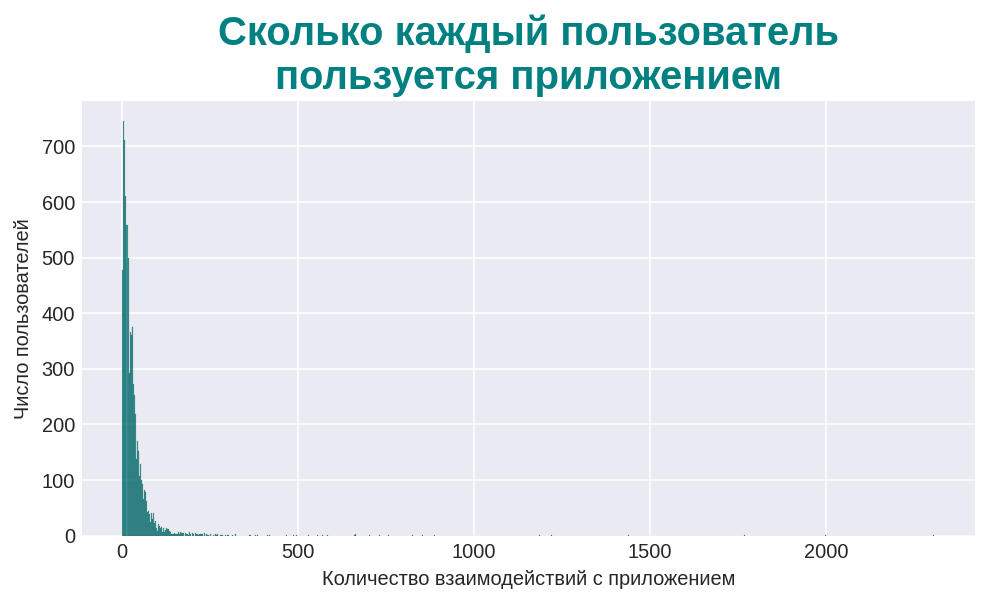

In [15]:
plt.figure(figsize=(8,4))
plt.title('Сколько каждый пользователь\nпользуется приложением', fontsize=20, fontweight='bold', color='teal')
sns.histplot(x='timestamp', data=users, color='teal')
plt.xlabel('Количество взаимодействий с приложением')
plt.ylabel('Число пользователей');

Приблизим график, чтобы лучше было видно основную часть распределения.

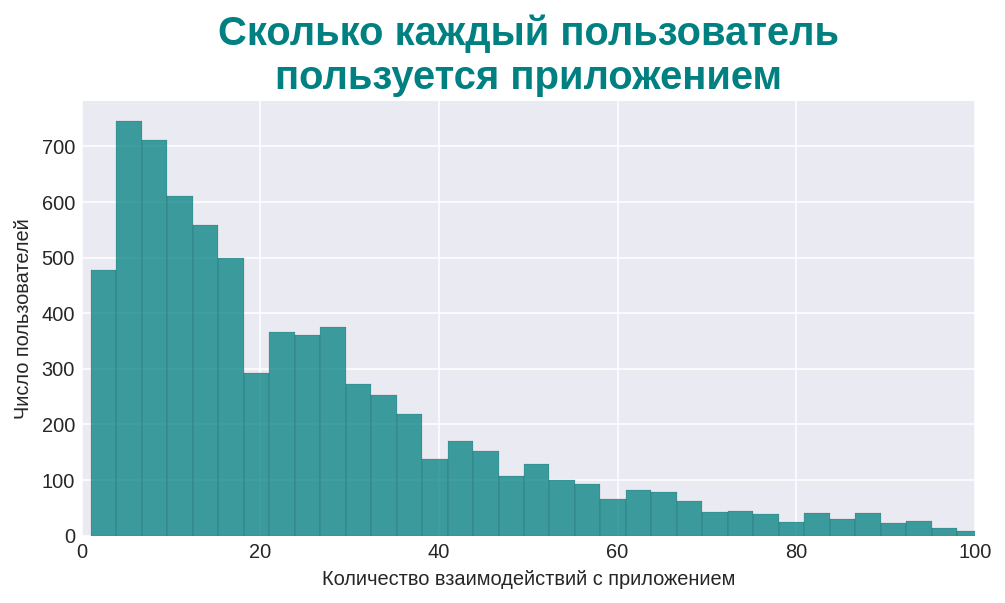

In [16]:
plt.figure(figsize=(8,4))
plt.title('Сколько каждый пользователь\nпользуется приложением', fontsize=20, fontweight='bold', color='teal')
sns.histplot(x='timestamp', data=users, color='teal')
plt.xlabel('Количество взаимодействий с приложением')
plt.ylabel('Число пользователей')
plt.xlim(0,100);

Большинство пользователей взаимодействуют с приложением небольшое число раз, почти все наблюдения находятся в диапазоне от 0 до 100, график очень сильно скошен вправо. Для такого распределения лучше подойдёт не среднее арифметическое, а мода. Посчитаем её.

In [17]:
users['timestamp'].mode()

0    5
dtype: int64

Большинство людей за время теста провзаимодействовали с приложением 5 раз. Скорее всего, они по разу прошли каждый из этапов.

Посмотрим, как распределены даты в нашем датасете.

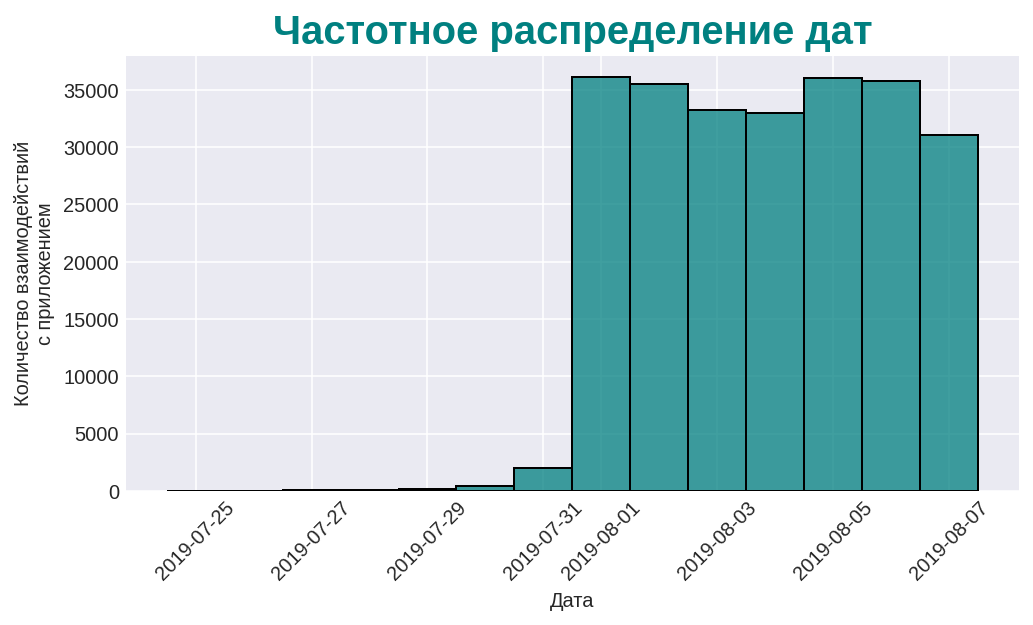

In [18]:
plt.figure(figsize=(8,4))
plt.title('Частотное распределение дат', fontsize=20, fontweight='bold', color='teal')
sns.histplot(x='day', data=df, color='teal')
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Количество взаимодействий\nс приложением');

Почти все данные на самом деле приходятся на промежуток **с 1 по 7 августа.** Добавим время, чтобы посмотреть на распределение внутри каждого дня.

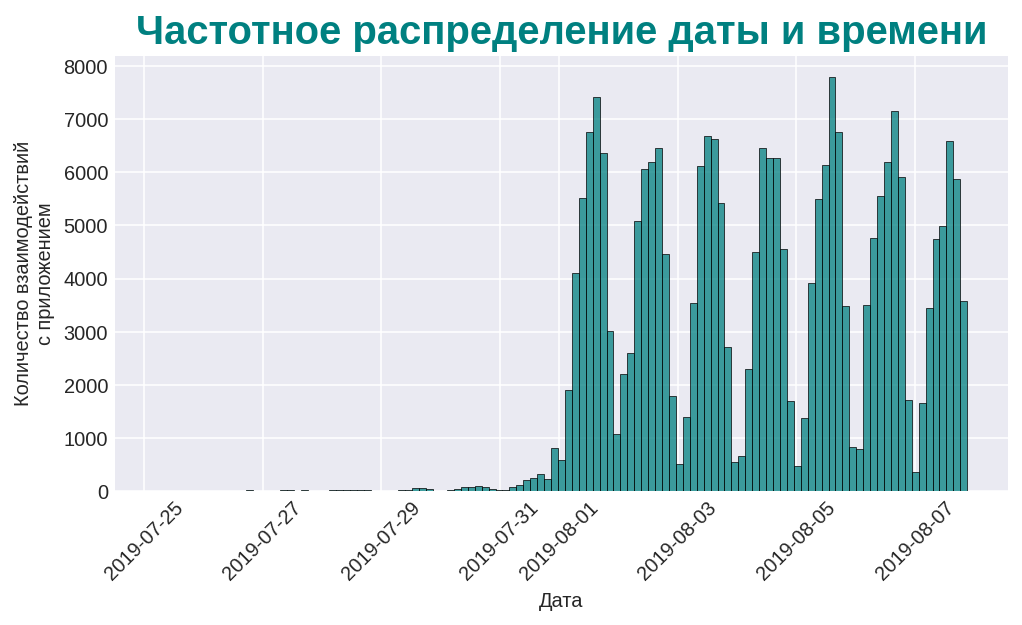

In [19]:
plt.figure(figsize=(8,4))
plt.title('Частотное распределение даты и времени', fontsize=20, fontweight='bold', color='teal')
sns.histplot(x='date', data=df, color='teal')
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Количество взаимодействий\nс приложением');

Внутри дней распределение похоже на нормальное. До 1 августа данных почти нет — от них лучше избавиться вовсе, чтобы не создавать перекос.

Поближе посмотрим на дату начала теста.

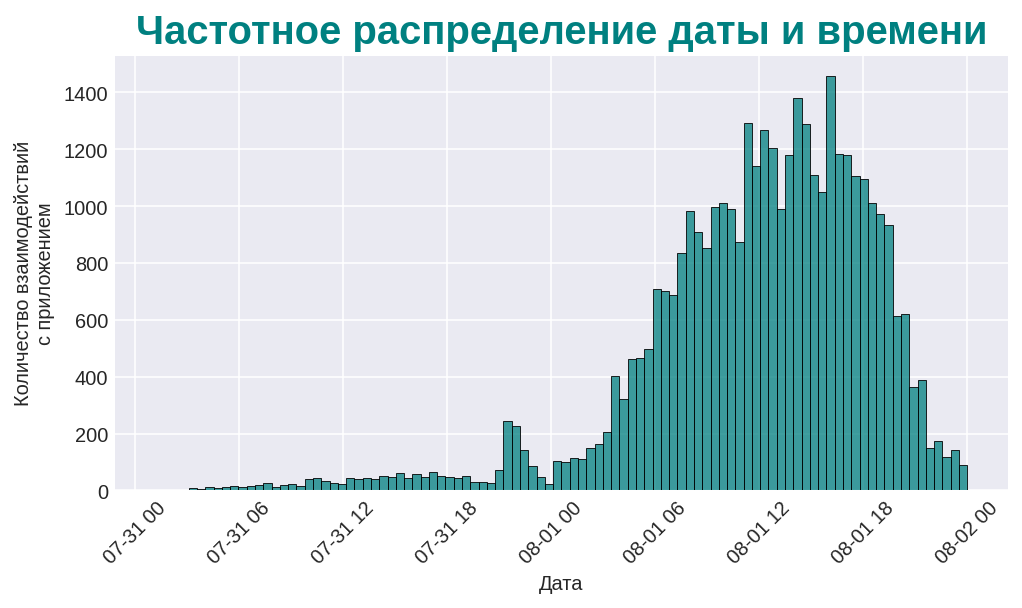

In [20]:
plt.figure(figsize=(8,4))
plt.title('Частотное распределение даты и времени', fontsize=20, fontweight='bold', color='teal')
sns.histplot(x='date', data=df.query('"2019-07-31"<=date<="2019-08-02"'), color='teal')
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Количество взаимодействий\nс приложением');

Судя по всему, тест начался примерно в 21:00 31 июля: виден вечерний «хвост» от распределения.

Создадим срез данных после 21:00 31 июля.

In [21]:
new_data = df[df['date']>=dt.datetime(2019, 7, 31, 21)]

Посчитаем, сколько строк и пользователей мы потеряли.

In [22]:
round(((df.shape[0] - new_data.shape[0]) / df.shape[0]) * 100, 2)

0.82

In [23]:
round(((df['id'].nunique() - new_data['id'].nunique()) / df['id'].nunique()) * 100, 2)

0.17

Потеряны меньше 1% строк и меньше 1/5 процента пользователей, но теперь данные стали более актуальными.

Проверим, сколько у нас пользователей в каждой группе — для А/В теста важно, чтобы группы были одного размера.

In [24]:
new_data.groupby('group')['id'].nunique()

group
246    2484
247    2517
248    2537
Name: id, dtype: int64

Между группами 246 и 248 есть небольшая разница в размере. Посчитаем, на сколько процентов группа 248 больше.

In [25]:
round((2537 / 2484 - 1) * 100, 2)

2.13

Группы почти одинаковые по количеству пользователей: самая большая разница между ними — чуть больше 2%. Проверим, нет ли в данных людей, которые попали больше чем в одну группу.

In [26]:
new_data.groupby('group')['id'].nunique().sum() - new_data['id'].nunique()

0

Таких людей нет.

### Вывод

В датасете были данные о прошлых пользователях. Чтобы избежать перекоса, мы сократили временной промежуток в 2 раза, потеряв при этом меньше 1% данных. Теперь данные более пригодны для анализа.

Группы одинаковые по размеру и между ними нет пересечений. Результаты А/В-теста не будут искажены.

<a id='an'></a>

## Анализируем данные

Посмотрим на воронку событий. Для этого сгруппируем данные по типу события и посчитаем уникальных пользователей, которые через это событие прошли. Отсортируем по убыванию количества пользователей.

In [27]:
events_by_users = (
    new_data
    .groupby('event', as_index=False)
    .agg({'id': 'nunique'})
    .sort_values('id', ascending=False)
    .rename(columns={'id': 'users'})
)

In [28]:
events_by_users

,event,users
1,MainScreenAppear,7423
2,OffersScreenAppear,4597
0,CartScreenAppear,3736
3,PaymentScreenSuccessful,3540
4,Tutorial,843


Как мы и выяснили на предыдущем этапе, у нас есть **4 основных события:**

1. Пользователь на главном экране.
2. На экране с выбором продуктов.
3. В корзине.
4. Оплата прошла успешно.

**Обучение не является частью воронки,** так что от него можно сразу избавиться.

In [29]:
events_by_users = events_by_users.iloc[0:4]

Посчитаем процент пользователей, прошедших через событие, от общего числа пользователей.

In [30]:
events_by_users['users_%'] = (events_by_users['users'] / new_data['id'].nunique() * 100).round(2)

Также посчитаем, сколько пользователей перешли с одного события на следующее.

In [31]:
events_by_users['churn'] = (events_by_users['users'].divide(events_by_users['users'].shift(1)) * 100).round(2)
events_by_users = events_by_users.fillna(events_by_users.loc[1, 'users_%'])

Изучим получившиеся данные.

In [32]:
events_by_users

,event,users,users_%,churn
1,MainScreenAppear,7423,98.47,98.47
2,OffersScreenAppear,4597,60.98,61.93
0,CartScreenAppear,3736,49.56,81.27
3,PaymentScreenSuccessful,3540,46.96,94.75


Больше всего пользователей мы теряем на этапе перехода с главного экрана на экран с предложениями. **Около 40% не уходят дальше главного экрана приложения.** При этом 4 из 5 посмотревших продукты переходят в корзину и почти все из них в итоге покупают то, что выбрали. Всего же от начала до успешной оплаты **доходят 47% пользователей.**

Посмотрим на воронку в разрезе групп. Построим столбчатую диаграмму для каждого события и группы.

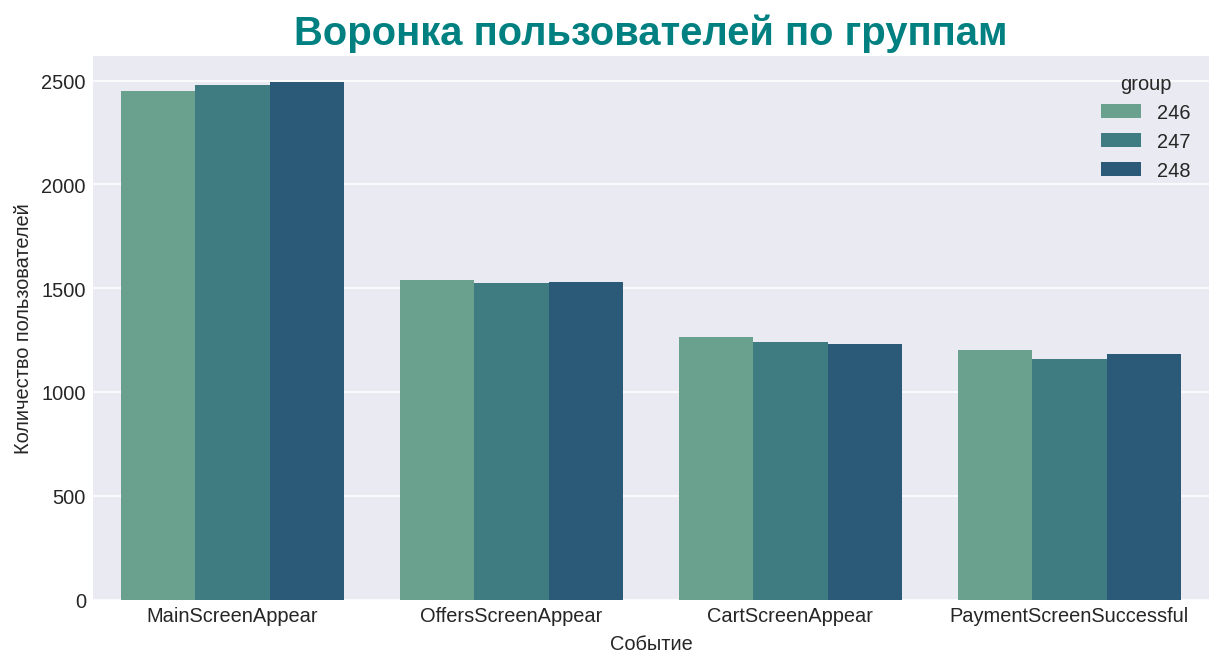

In [33]:
plt.figure(figsize=(10,5))
plt.title('Воронка пользователей по группам', fontsize=20, fontweight='bold', color='teal')
sns.barplot(
    x='event',
    y='id',
    hue='group',
    data=(
        new_data
        .groupby(['event', 'group'], as_index=False)
        .agg({'id': 'nunique'})
        .query('event!="Tutorial"')
        .sort_values('id', ascending=False)),
    palette='crest'
)
plt.xlabel('Событие')
plt.ylabel('Количество пользователей');

Из графика видно, что в целом количество уникальных пользователей, прошедших через событие, почти **не меняется в зависимости от группы.** Кажется, изменение шрифта не привело ни к росту, ни к снижению конверсии перехода на следующий этап.

Посмотрим, изменилось ли количество событий внутри группы в целом.

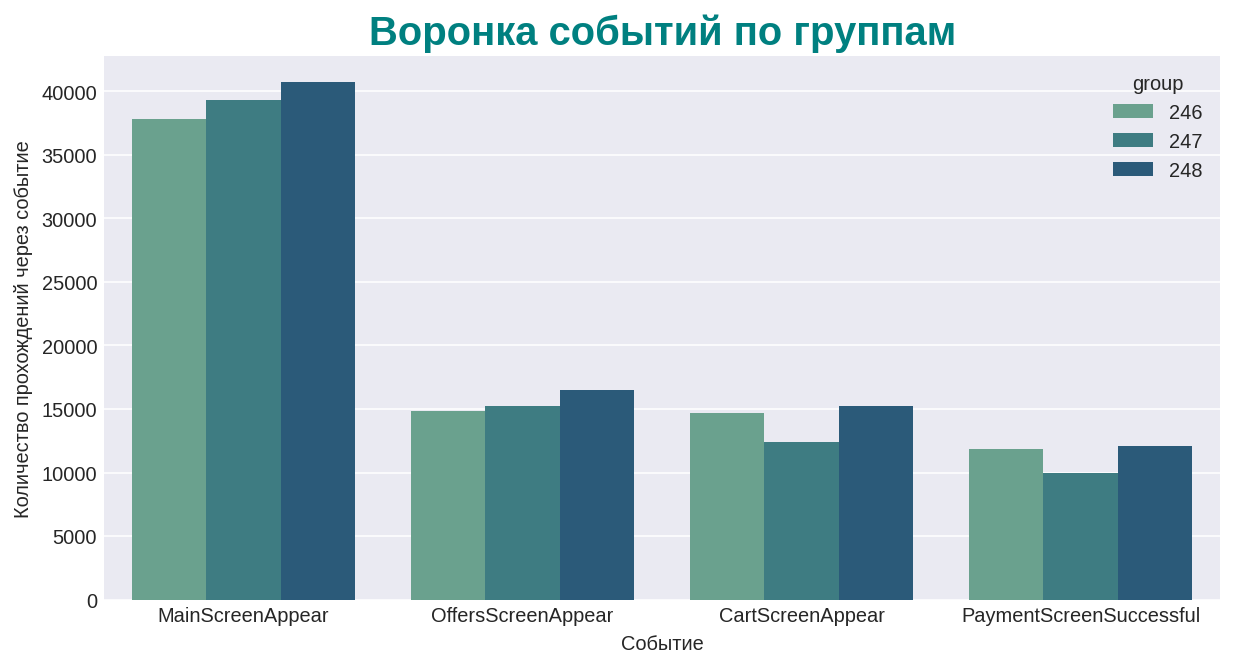

In [34]:
plt.figure(figsize=(10,5))
plt.title('Воронка событий по группам', fontsize=20, fontweight='bold', color='teal')
sns.barplot(
    x='event',
    y='id',
    hue='group',
    data=(
        new_data
        .groupby(['event', 'group'], as_index=False)
        .agg({'id': 'count'})
        .query('event!="Tutorial"')
        .sort_values('id', ascending=False)),
    palette='crest'
)
plt.xlabel('Событие')
plt.ylabel('Количество прохождений через событие');

Кажется, пользователи тестовой группы в среднем чаще стали пользоваться приложением: уникальных пользователей на всех этапах столько же, а вот всего прохождений первых двух этапов в группе 248 заметно больше. Возможно, конверсия перехода на следующий этап не увеличилась, но из-за нового шрифта пользователи в целом стали чаще пользоваться приложением и чаще заказывать.

**На данном этапе можно сформулировать две нулевые гипотезы:**
1. Доля пользователей, переходящих на каждый следующий этап, не изменилась.
2. Среднее количество событий на пользователя не изменилось.

Проверим их позже.

Посмотрим, как изменялось кумулятивное количество событий по дням.

In [35]:
dates_groups = new_data[['day', 'group']].drop_duplicates()
cum_data = (
    dates_groups
    .apply(
        lambda x:
        new_data[
            (new_data['day']<=x['day'])&(new_data['group']==x['group'])
        ]
        .agg({
            'day': 'max',
            'group': 'max',
            'id': 'count'
        }),
        axis=1)
    .sort_values(['day', 'group'])
)

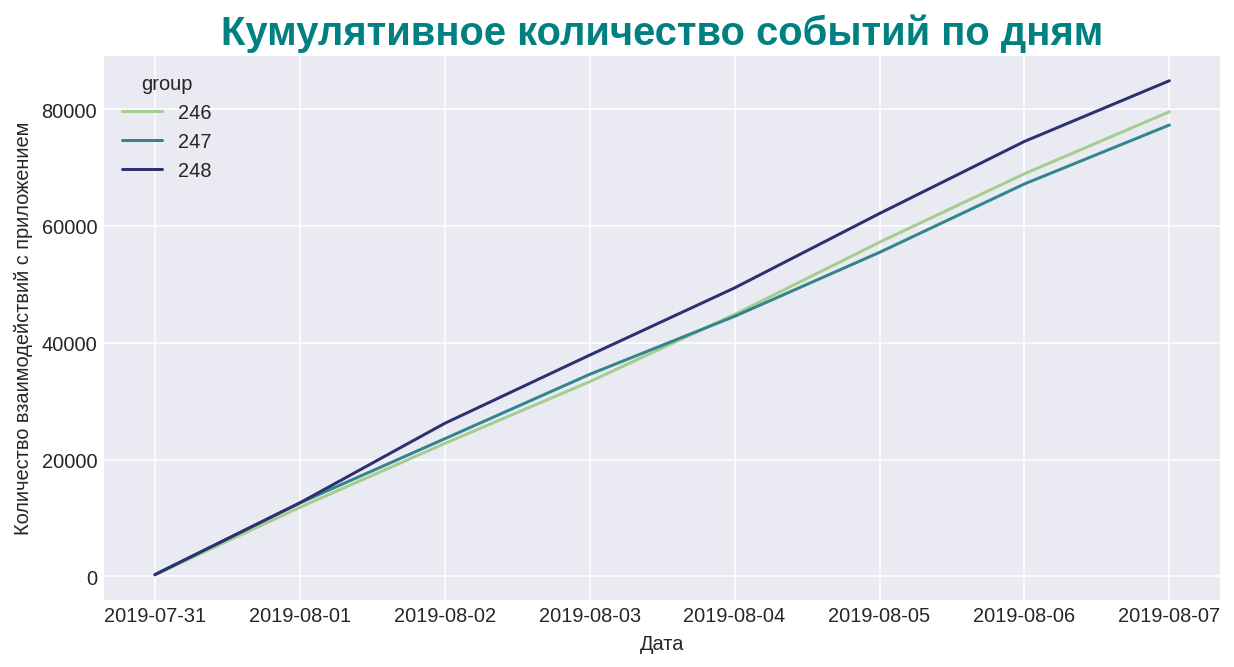

In [36]:
plt.figure(figsize=(10,5))
plt.title('Кумулятивное количество событий по дням', fontsize=20, fontweight='bold', color='teal')
sns.lineplot(
    x='day',
    y='id',
    hue='group',
    data=cum_data,
    palette='crest')
plt.xlabel('Дата')
plt.ylabel('Количество взаимодействий с приложением');

**Тестовая группа заметно опережает контрольные.** Пока что предположение о том, что пользователи стали чаще пользоваться приложением, подтверждается. Посмотрим на графики, разбитые по событиям.

In [37]:
dates_groups_events = new_data.query('event!="Tutorial"')[['day', 'group', 'event']].drop_duplicates()
cum_data_by_event = (
    dates_groups_events
    .apply(
        lambda x:
        new_data[
            (new_data['day']<=x['day'])&(new_data['group']==x['group'])&(new_data['event']==x['event'])
        ]
        .agg({
            'day': 'max',
            'event': 'max',
            'group': 'max',
            'id': 'count'
        }),
        axis=1)
    .sort_values(['day', 'group', 'event'])
)

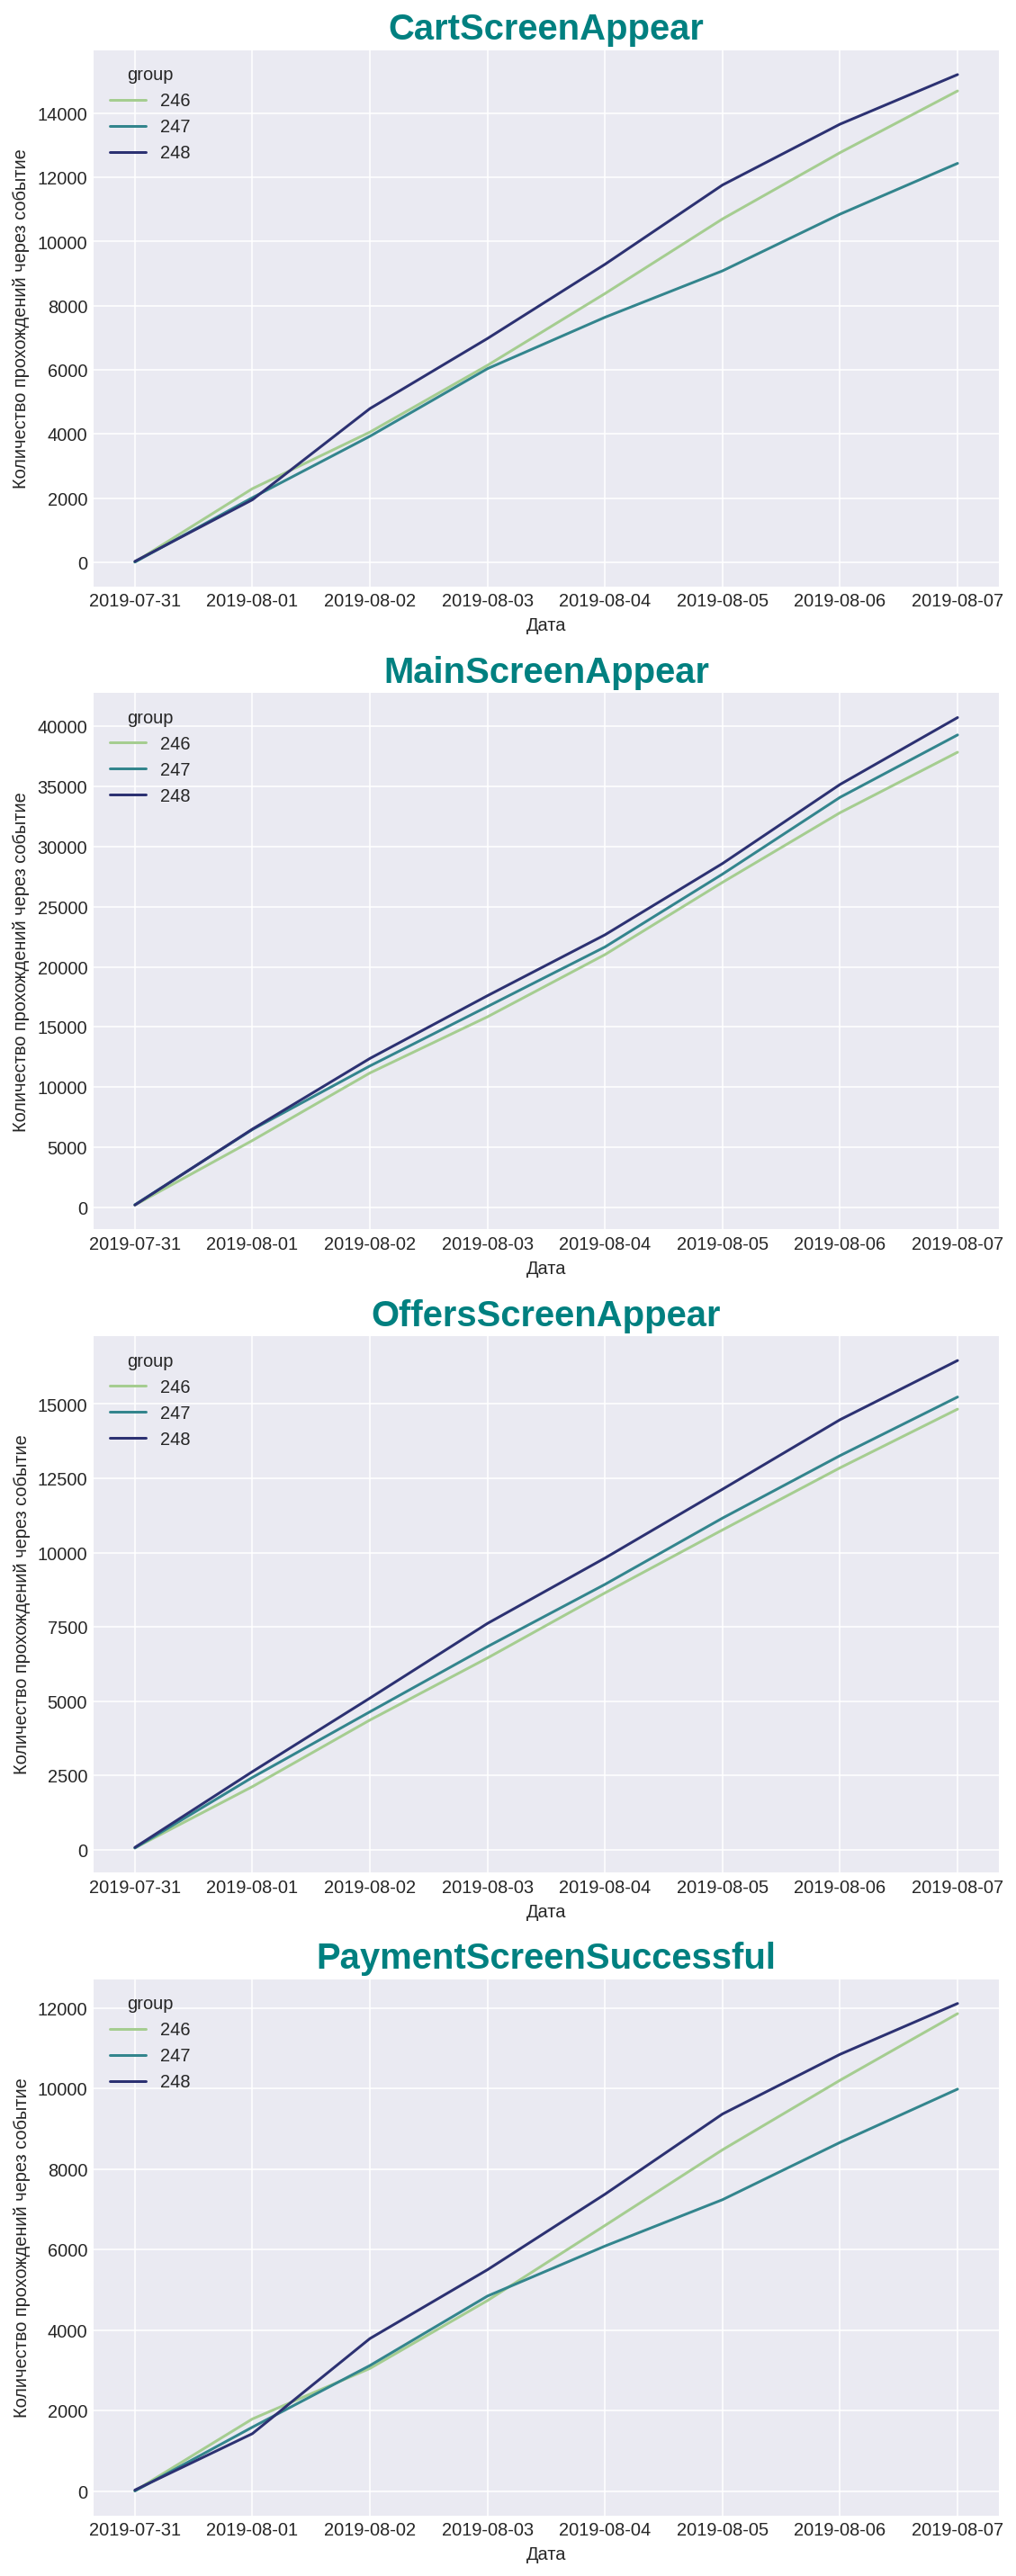

In [38]:
fig, axes = plt.subplots(4, 1, figsize=(8, 20))
for i, event in enumerate(cum_data_by_event['event'].unique()):
    axes[i].set_title(event, fontsize=20, fontweight='bold', color='teal')
    sns.lineplot(
        x='day',
        y='id',
        hue='group',
        data=cum_data_by_event.query('event==@event'),
        ax=axes[i],
        palette='crest')
    axes[i].set_xlabel('Дата')
    axes[i].set_ylabel('Количество прохождений через событие')
fig.tight_layout()

Снова тестовая группа заметно опережает контрольные на всех этапах, кроме главного экрана. Также на этапах корзины и успешной оплаты показатели группы 246 сильно отличаются от 247-й и даже ближе к тестовой группе, чем ко второй контрольной. Возможно, дело не в шрифтах, а в выбросах. Посмотрим на разброс значений количества событий в каждой группе.

In [39]:
data_for_boxplot = (
    new_data
    .query('event!="Tutorial"')
    .groupby(['id', 'group', 'event'])
    .agg({'timestamp': 'count'})
    .reset_index()
)

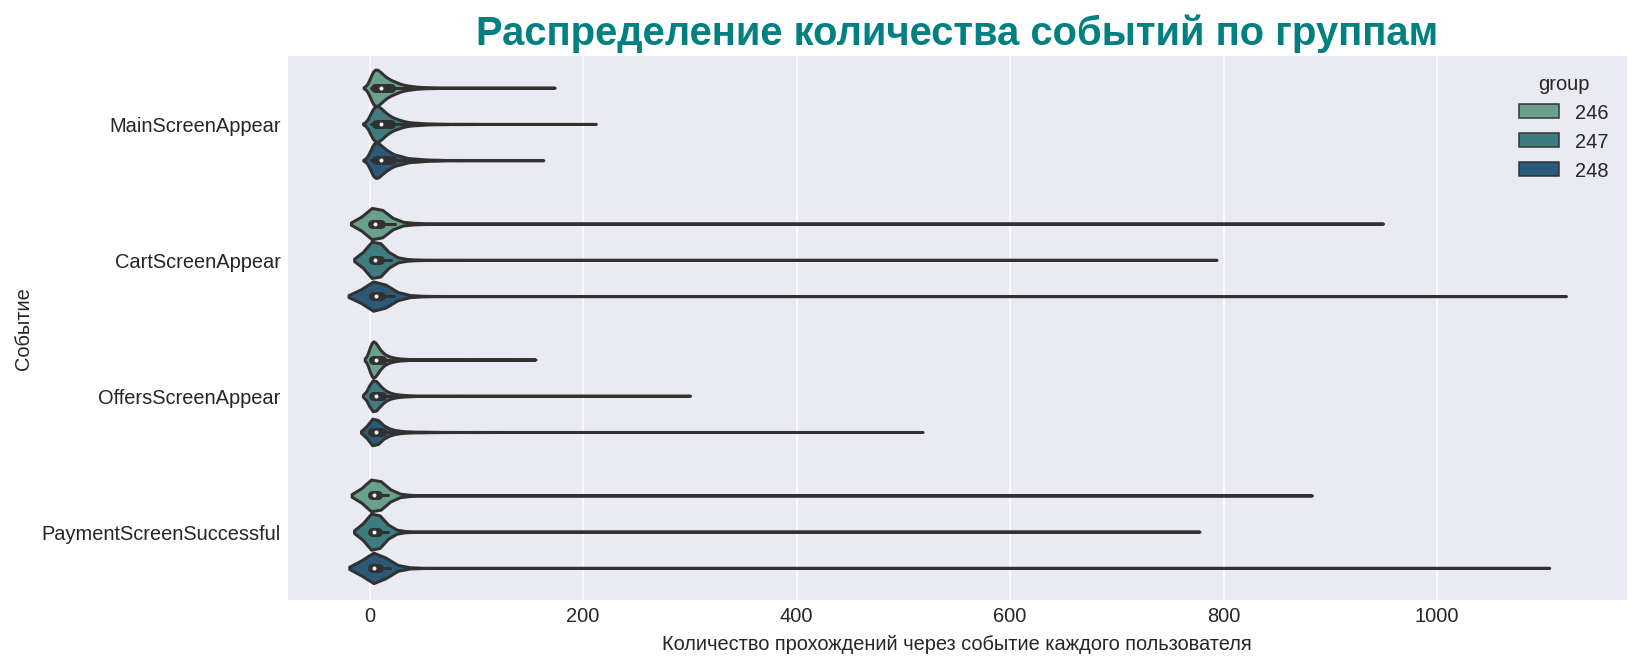

In [40]:
plt.figure(figsize=(12,5))
plt.title('Распределение количества событий по группам', fontsize=20, fontweight='bold', color='teal')
sns.violinplot(
    x='timestamp',
    y='event',
    hue='group',
    data=data_for_boxplot,
    orient='h',
    palette='crest')
plt.xlabel('Количество прохождений через событие каждого пользователя')
plt.ylabel('Событие');

Из графика видно, что на всех этапах, кроме главного экрана, в тестовой группе (нижняя в каждой тройке) — **самые большие выбросы.** Возможно, именно это привело к увеличению на прошлых графиках. Приблизим диаграммы размаха и посмотрим, отличаются ли меры центральной тенденции.

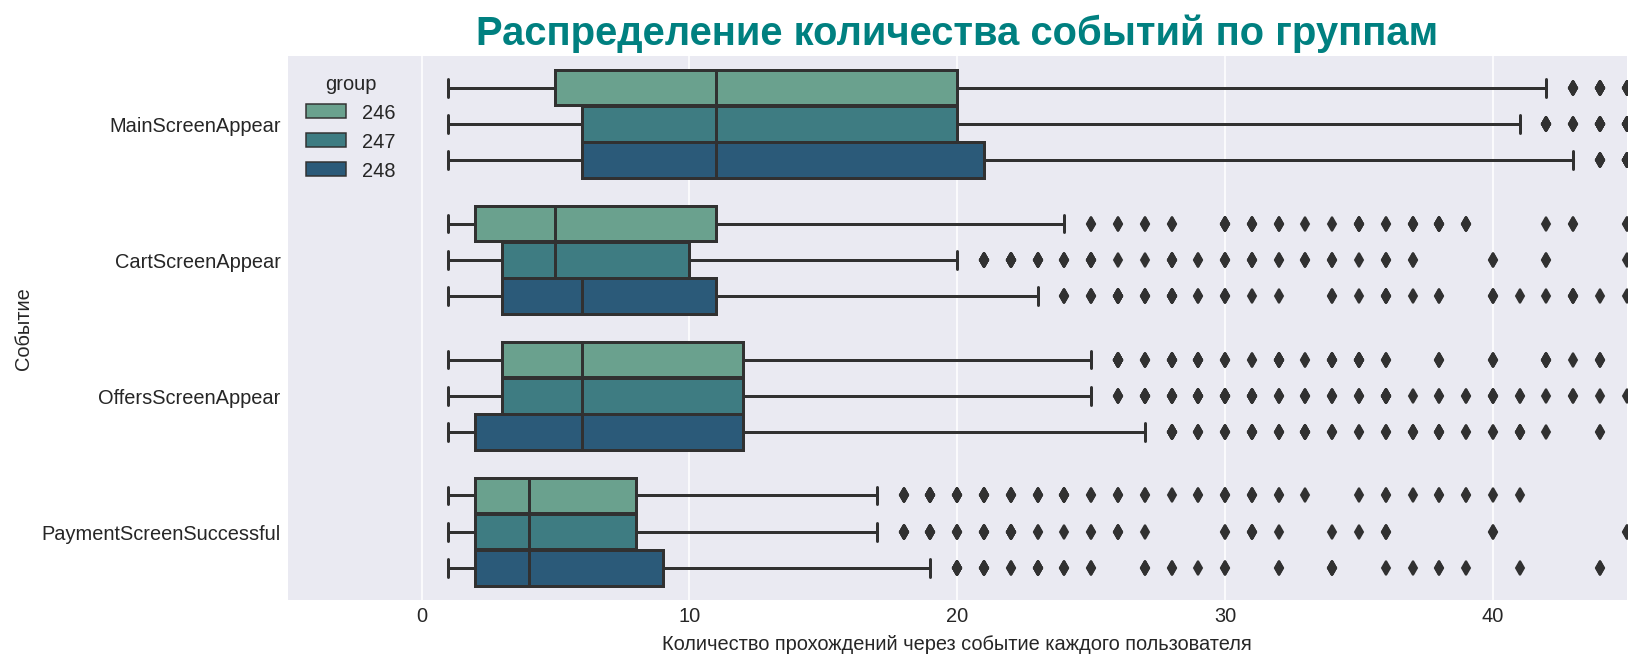

In [41]:
plt.figure(figsize=(12,5))
plt.title('Распределение количества событий по группам', fontsize=20, fontweight='bold', color='teal')
sns.boxplot(
    x='timestamp',
    y='event',
    hue='group',
    data=data_for_boxplot,
    orient='h',
    palette='crest')
plt.xlim(-5, 45)
plt.xlabel('Количество прохождений через событие каждого пользователя')
plt.ylabel('Событие');

Теперь ясно, что рост на предыдущих графиках произошёл **только под влиянием выбросов.** Ни медиана, ни 25-й и 75-й квартили не отличаются ни у одной из групп. Видимо, изменение шрифта вообще никак не повлияло на активность пользователей. Просто в тестовую группу попали один или несколько пользователей, которые делали очень много заказов.

<a id='hyps'></a>

## Проверяем гипотезы

В прошлом шаге мы сформулировали две гипотезы:
1. Конверсии переходов на следующий этап во всех группах равны.
2. Среднее количество каждого события на пользователя во всех группах одинаковое.

Проверим эти гипотезы при помощи z-теста. Для начала создадим сводную таблицу, в которой каждому событию будет соответствовать число пользователей, которые через него прошли.

In [42]:
pivot_events_by_groups_nunique = (
    new_data
    .query('event!="Tutorial"')
    .pivot_table(
        index='event',
        columns='group',
        values='id',
        aggfunc='nunique')
    .sort_values(246, ascending=False)
)

In [43]:
pivot_events_by_groups_nunique

group,246,247,248
event,,,
MainScreenAppear,2450,2479,2494
OffersScreenAppear,1542,1524,1531
CartScreenAppear,1266,1239,1231
PaymentScreenSuccessful,1200,1158,1182


Теперь напишем функцию, которая будет принимать датафрейм и две группы, а возвращать p-уровень значимости различий между группами для каждого события.

Когда мы сравним все группы между собой, у нас получится 9 значений p-value. p-value — это вероятность получить наблюдаемые или более значимые различия между группами при условии, что нулевая гипотеза верна. Если выбрать слишком высокий порог уровня значимости для нашего эксперимента (например, 0.1), то в 1 случае из 10 мы будем случайно получать значимые различия. А поскольку экспериментов у нас 9, то **мы почти наверняка хотя бы раз совершим ошибку первого рода** — то есть отвергнем нулевую гипотезу, хотя значимых различий на самом деле не будет. Чтобы этого избежать, воспользуемся поправкой Бонферрони.

In [44]:
def ztest_2samp(data, group1, group2):
    '''Возвращает p-value для каждого события.
    
    Параметры:
    data (DataFrame) — датасет, из которого извлекаются выборки.
    group1 (int) — номер первой группы для сравнения.
    group2 (int) — номер второй группы для сравнения.
    '''
    for i in data.index:
        if i != 'MainScreenAppear':
            pvalue = proportions_ztest(
                [data.loc[i, group1],
                 data.loc[i, group2]],
                [data.loc['MainScreenAppear', group1],
                 data.loc['MainScreenAppear', group2]])[1]
            alpha = .05
            bonf_alpha = alpha / 9
            bonf_alpha
            if pvalue < bonf_alpha:
                print(i, 'p-value' + ':', pvalue.round(4), '—', 'Отвергаем Ho')
            else:
                print(i, 'p-value' + ':', pvalue.round(4), '—', 'Не получилось отвергнуть Ho')

При помощи функции посчитаем уровень значимости для нулевой гипотезы о том, что конверсия перехода на следующий этап для групп 246 и 247 одинаковая. Альтернативная гипотеза: конверсии переходов различаются.

In [45]:
ztest_2samp(pivot_events_by_groups_nunique, 246, 247)

OffersScreenAppear p-value: 0.2897 — Не получилось отвергнуть Ho
CartScreenAppear p-value: 0.2344 — Не получилось отвергнуть Ho
PaymentScreenSuccessful p-value: 0.1111 — Не получилось отвергнуть Ho


p-уровень значимости во всех случаях получился довольно высоким. Можно принять предположение о том, что значимых изменений в группах 246 и 247 не произошло. Эти две группы — контрольные. **Отсутствие различий говорит о том, что данные в порядке.**

То же самое проделаем с группами 246 и 248 — тестовой и одной из контрольных.

In [46]:
ztest_2samp(pivot_events_by_groups_nunique, 246, 248)

OffersScreenAppear p-value: 0.2608 — Не получилось отвергнуть Ho
CartScreenAppear p-value: 0.1036 — Не получилось отвергнуть Ho
PaymentScreenSuccessful p-value: 0.2645 — Не получилось отвергнуть Ho


Результат тот же. **Между тестовой группой и одной из контрольных нет значимых различий** в количестве переходов с одного этапа на следующий. Проверим различия групп 247 и 248.

In [47]:
ztest_2samp(pivot_events_by_groups_nunique, 247, 248)

OffersScreenAppear p-value: 0.9486 — Не получилось отвергнуть Ho
CartScreenAppear p-value: 0.6612 — Не получилось отвергнуть Ho
PaymentScreenSuccessful p-value: 0.6303 — Не получилось отвергнуть Ho


То же самое проделаем для тестовой группы и объединения двух контрольных: для этого создадим столбец с общей суммой пользователей.

p-value даже выше, чем в прошлых тестах. Почти наверняка **группы 247 и 248 значимо не различаются** по количеству пользователей, переходящих с одного этапа на другой.

In [48]:
pivot_events_by_groups_nunique['246+247'] = pivot_events_by_groups_nunique[246] + pivot_events_by_groups_nunique[247]

$Н_0$: Конверсии перехода с одного этапа на следующий не отличаются. $Н_1$: Конверсии перехода с одного этапа на следующий различаются.

In [49]:
ztest_2samp(pivot_events_by_groups_nunique, '246+247', 248)

OffersScreenAppear p-value: 0.4941 — Не получилось отвергнуть Ho
CartScreenAppear p-value: 0.2337 — Не получилось отвергнуть Ho
PaymentScreenSuccessful p-value: 0.7166 — Не получилось отвергнуть Ho


Снова мы получили очень высокий p-value. Можно уверенно говорить о том, что **между контрольными и тестовой группой нет значимых различий.**

#### Вывод

Первое предположение подтвердилось: изменение шрифта никак не повлияло на желание пользователей переходить на следующий этап и заказывать товары.

**NB:** Поправка Бонферрони сильно снижает мощность теста, но полученные p-value так велики, что вероятность совершить ошибку второго рода и случайно принять нулевую гипотезу при наличии значимых различий крайне мала.

Проверим вторую гипотезу: среднее количество событий на пользователя в группах одинаковое. Для этого посчитаем, сколько раз каждый пользователь проходил через каждое событие. Датафрейм не подойдёт: нам нужно избавиться от выбросов в данных о каждом событии в каждой группе — списки получатся разной длины. При помощи цикла создадим словарь, где каждому событию в каждой группе будет соответствовать очищенный от выбросов список с количеством раз, которое пользователь из этой группы прошёл через это событие.

In [50]:
clean_dict = {} # создадим пустой словарь
clean_list_for_bar = [] # также создадим пустой список, в который сложим суммы заходов для визуализации
for group in new_data['group'].unique():
    pivot_group = ( # создадим сводную таблицу, в которой каждому пользователю будет соответствовать
        new_data    # число прохождений через определенное событие
        .query('group==@group and event!="Tutorial"')
        .pivot_table(
            index='id',
            columns='event',
            values='timestamp',
            aggfunc='count')
        .fillna(0) # если данных нет, значит, пользователь ни разу не проходил через событие, заполним пропуски нулями
    )
    for col in pivot_group.columns:
        percentile_95 = np.percentile(pivot_group[col], 95) # для каждого события посчитаем 95-% перцентиль
        clean_list = pivot_group.loc[pivot_group[col]<=percentile_95, col].to_list() # создадим срез с очищенными данными и сделаем из него список
        list_sum = sum(clean_list) # посчитаем сумму для списка
        clean_list_for_bar.append([group, col, list_sum]) # добавим к списку полученные значения
        clean_dict[col + '_' + str(group)] = clean_list # добавим очищенный список к словарю
columns_for_df = ['group', 'event', 'count'] # список с названиями столбцов
clean_df_for_bar = pd.DataFrame(clean_list_for_bar, columns=columns_for_df) # преобразуем список в датафрейм

Визуализируем полученный датафрейм. Посмотрим, как изменились данные после очистки от выбросов.

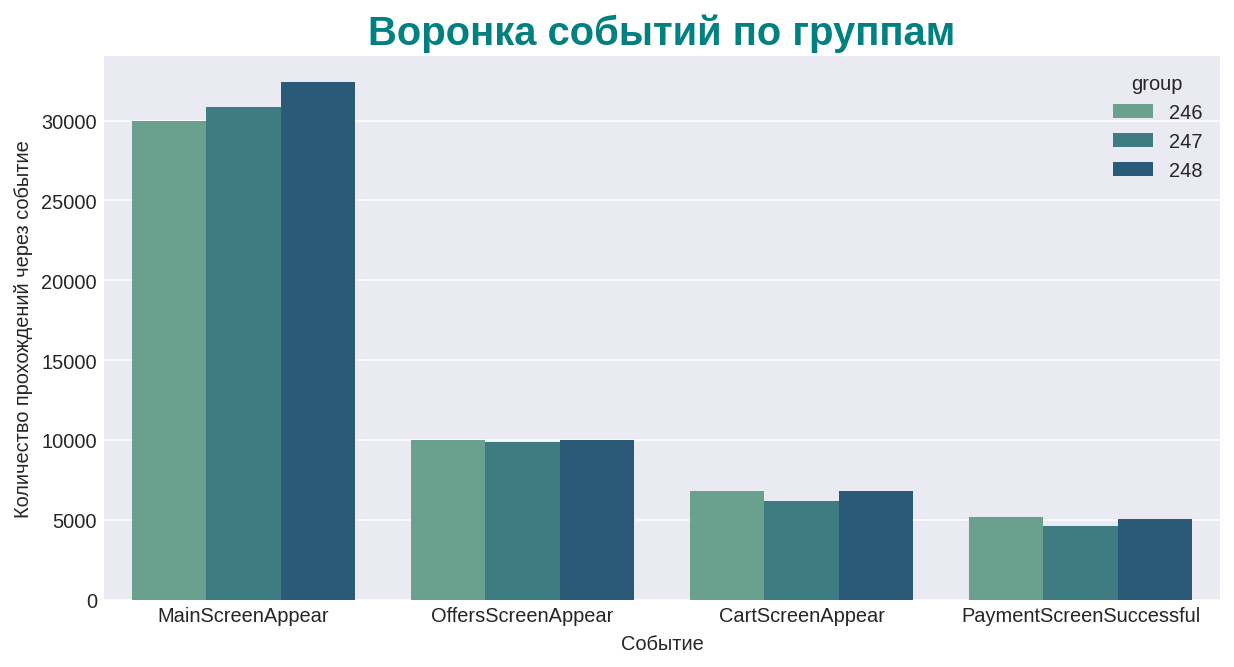

In [51]:
plt.figure(figsize=(10,5))
plt.title('Воронка событий по группам', fontsize=20, fontweight='bold', color='teal')
sns.barplot(
    x='event',
    y='count',
    hue='group',
    data=clean_df_for_bar.sort_values('count', ascending=False),
    palette='crest')
plt.xlabel('Событие')
plt.ylabel('Количество прохождений через событие');

Предположение подтвердилось: рост в группе 248 был достигнут **только за счёт выбросов.** Очищенные данные не показывают никакого увеличения числа прохождений через события (виден рост на первом этапе, но он мог получиться за счёт чуть большего размера группы). Проверим это статистически.

In [52]:
# создадим таблицу-словарь для использования в цикле
events_groups_dict = []
for i, val in enumerate(list(clean_dict)):
    events_groups_dict.append([i, val])
events_groups_dict = pd.DataFrame(events_groups_dict, columns=['i', 'val'])

С помощью цикла проверим сразу несколько гипотез:
1. $Н_0$: Среднее количество событий в двух контрольных группах одинаковое. $Н_1$: Среднее количество событий в двух контрольных группах разное.
2. $Н_0$: Среднее количество событий в контрольной и тестовой группе одинаковое. $Н_1$: Среднее количество событий в контрольной и тестовой группе разное.

In [53]:
pvalue_list = [] # создадим список, в который сложим все p-value
for i in range(events_groups_dict.shape[0]):
    if i < 4:
        pvalue_list.append([events_groups_dict.loc[i, 'val'] + ' x ' + events_groups_dict.loc[i+4, 'val'],
                            st.mannwhitneyu(
                                clean_dict[events_groups_dict.loc[i, 'val']],
                                clean_dict[events_groups_dict.loc[i+4, 'val']]).pvalue])
        pvalue_list.append([events_groups_dict.loc[i, 'val'] + ' x ' + events_groups_dict.loc[i+8, 'val'],
                            st.mannwhitneyu(
                                clean_dict[events_groups_dict.loc[i, 'val']],
                                clean_dict[events_groups_dict.loc[i+8, 'val']]).pvalue])
        pvalue_list.append([events_groups_dict.loc[i+4, 'val'] + ' x ' + events_groups_dict.loc[i+8, 'val'],
                            st.mannwhitneyu(
                                clean_dict[events_groups_dict.loc[i+4, 'val']],
                                clean_dict[events_groups_dict.loc[i+8, 'val']]).pvalue])

Создадим датафрейм, где каждой проверке будет соответствовать получившийся p-value.

In [54]:
pvalue_df = pd.DataFrame(pvalue_list, columns=['event_group', 'p_value'])

Визуализируем данные: построим столбчатую диаграмму полученных уровней значимости, а также проведём линию, соответствующую p-value = 0.05 и p-value с учетом поправки Бонферрони, чтобы увидеть, какие из нулевых гипотез можно отвергнуть.

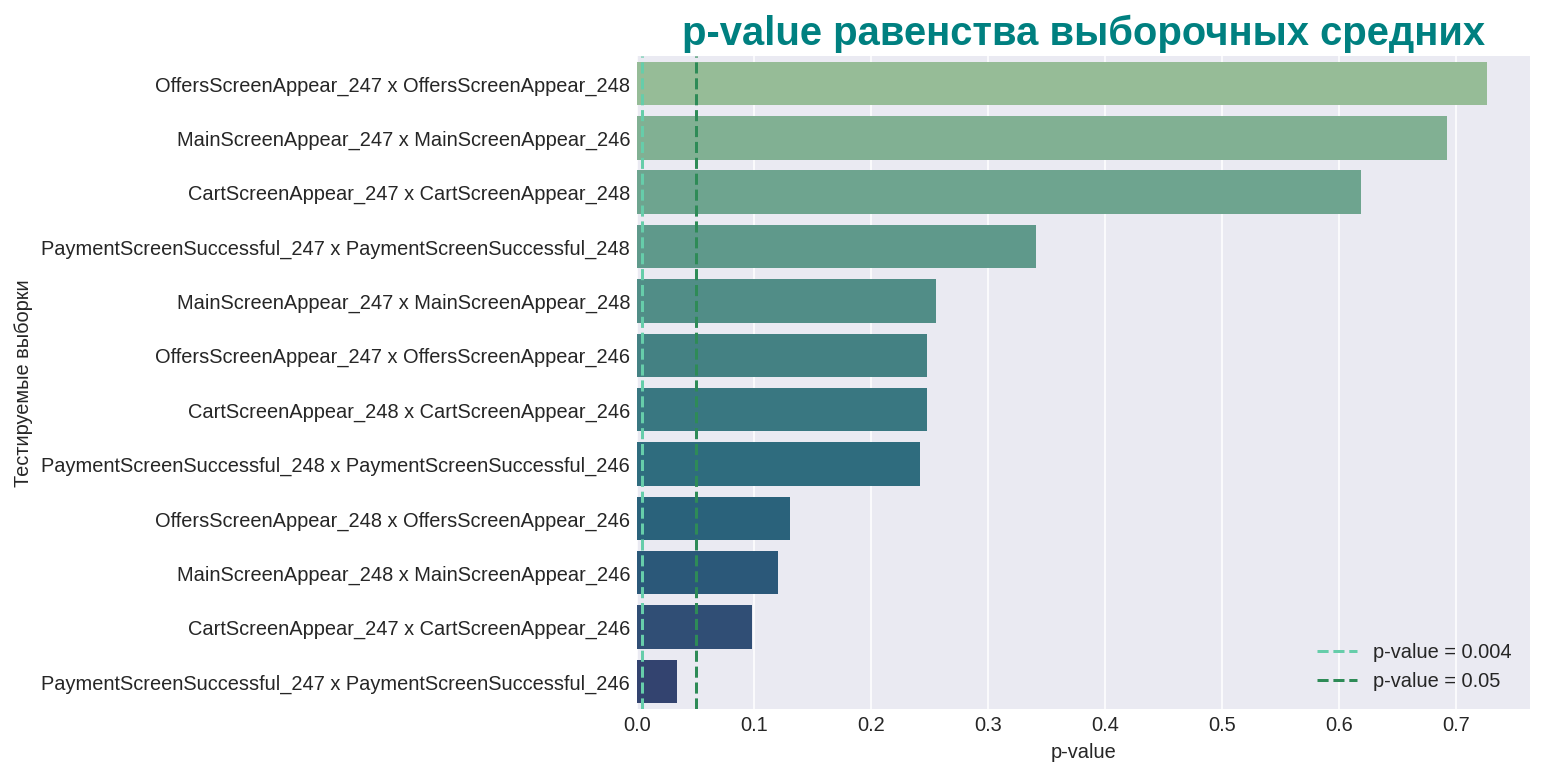

In [55]:
plt.figure(figsize=(8,6))
plt.title('p-value равенства выборочных средних', fontsize=20, fontweight='bold', color='teal')
sns.barplot(
    x='p_value',
    y='event_group',
    data=pvalue_df.sort_values('p_value', ascending=False),
    orient='h',
    palette='crest')
plt.axvline(
    0.05 / pvalue_df.shape[0],
    linestyle='--',
    color='mediumaquamarine',
    label='p-value = {0:.3f}'.format((0.05 / pvalue_df.shape[0])))
plt.axvline(
    0.05,
    linestyle='--',
    color='seagreen',
    label='p-value = 0.05')
plt.legend()
plt.xlabel('p-value')
plt.ylabel('Тестируемые выборки');

Ни в одном из тестов не были достигнуты статистически значимые различия выборочных средних. Отличия в количестве прохождений этапа успешной оплаты в двух контрольных группах (p-value меньше 0.05, но больше, чем критическое значение с учетом поправки) нельзя считать значимым. Из-за множественности тестов такой результат мог получиться случайно. Можно говорить о том, что ни в одной группе среднее количество прохождений каждого пользователя через событие значимо не изменилось.

<a id='conclude'></a>

## Итоговый вывод

В ходе проекта мы изучили данные об использовании приложения за 2 недели: с 25 июля по 7 августа 2019 года. Прежде чем анализировать датасет, подготовили его:
1. Убедились, что все типы данных правильные и нет пропущенных значений.
2. Удалили дубликаты (их было немного — чуть больше 400).
3. Убрали первую неделю: данных о ней почти не было.

После подготовки мы получили данные с 1 по 7 августа, потеряв меньше 1% строк. Так мы улучшили данные и избежали перекосов.

Анализ пользовательских событий показал, что люди проходили через следующую воронку:
1. Пользователь на главном экране приложения.
2. Пользователь на экране с выбором продуктов.
3. Пользователь на экране корзины с продуктами.
4. Оплата прошла успешно.

Также в таблице есть информация о прохождении обучения, но этот этап не входит в воронку.

Изучив воронку событий, мы выяснили, что около 40% пользователей не уходят дальше главного экрана, но те, кто прошли дальше, почти наверняка покупали товары. 47% всех пользователей прошли от начала до успешной оплаты.

Визуальный анализ воронок по группам показал, что изменение шрифта не повлияло на конверсию перехода пользователя на следующий этап в приложении. После избавления от выбросов мы также убедились, что нововведение не повлияло и на среднее количество прохождений пользователя через события.

Чтобы подтвердить предположения, сделанные во время анализа данных, мы провели статистические тесты: при помощи Z-теста сравнили конверсии переходов на следующий этап между группами, а также при помощи U-теста Манна-Уитни проверили значимость различий между средним числом прохождений через событие. С учётом поправки на множественность тестов ни один эксперимент не показал значимых различий ни между контрольными группами, ни между тестовой и контрольными.

В результате можно сделать следующий вывод: **изменение шрифта в приложении значимо не повлияло на активность пользователей.**
1. Количество пользователей, переходящих с одного этапа на другой, значимо не меняется ни в контрольных, ни в тестовой группе.
2. Среднее число прохождений каждого пользователя через событие значимо не отличается ни в котрольных, ни в тестовой группе.

С одной стороны, внедрение нового шрифта потребует ресурсов разработки. С другой стороны, он уже внедрен для тестовой группы, и нужно только распространить изменение на всех пользователей. Если это не потребует больших затрат, это можно сделать, не боясь за снижение показателей (но и роста ждать не стоит).